<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulation" data-toc-modified-id="Simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Generate-Petri-Net" data-toc-modified-id="Generate-Petri-Net-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate Petri Net</a></span></li><li><span><a href="#Create-Reachability-Graph" data-toc-modified-id="Create-Reachability-Graph-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create Reachability Graph</a></span></li><li><span><a href="#Simulate-Event-Logs" data-toc-modified-id="Simulate-Event-Logs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Simulate Event Logs</a></span></li></ul></li><li><span><a href="#Deep-Learning" data-toc-modified-id="Deep-Learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Deep Learning</a></span><ul class="toc-item"><li><span><a href="#Simple-LSTM" data-toc-modified-id="Simple-LSTM-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simple-LSTM</a></span></li></ul></li></ul></div>

# Experiment 1

## Simulation

### Generate Petri Net

In [1]:
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils
from sklearn.metrics import confusion_matrix
import pm4py
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
net = PetriNet("new_petri_net")


In [3]:
transition_names= [ 
'Invoice Accepted',
'Pay Expenses',
'Check receipt',
'Finish',
'Check Invoice',
'Archive Invoice',
]

In [4]:
places=[]
for i in range(8):
    p=PetriNet.Place(str(i))
    net.places.add(p)
    places.append(p)

In [5]:
transitions=[]
for i,tn in enumerate(transition_names):
    t=PetriNet.Transition(str(i),tn)
    net.transitions.add(t)
    transitions.append(t)

In [6]:
places

[0, 1, 2, 3, 4, 5, 6, 7]

In [7]:
places,transitions

([0, 1, 2, 3, 4, 5, 6, 7],
 [(0, 'Invoice Accepted'),
  (1, 'Pay Expenses'),
  (2, 'Check receipt'),
  (3, 'Finish'),
  (4, 'Check Invoice'),
  (5, 'Archive Invoice')])

In [8]:
def add_arc_from_place(p,t):
    petri_utils.add_arc_from_to(places[p], transitions[t], net)
def add_arc_from_transition(t,p):
    petri_utils.add_arc_from_to(transitions[t],places[p], net)

for i in range(4):
    add_arc_from_place(i,i)
    add_arc_from_transition(i,i+1)
    
add_arc_from_transition(0,5)
add_arc_from_place(5,4)
add_arc_from_transition(4,6)
add_arc_from_place(6,5)
add_arc_from_transition(5,7)
#add_arc_from_transition(5,7)
#add_arc_from_transition(0,6)
#add_arc_from_transition(0,6)

    

In [9]:
initial_marking=Marking()
initial_marking[places[0]]=1
#final_marking=Marking()
#final_marking[places[4]]=1
# final_marking[places[7]]=1

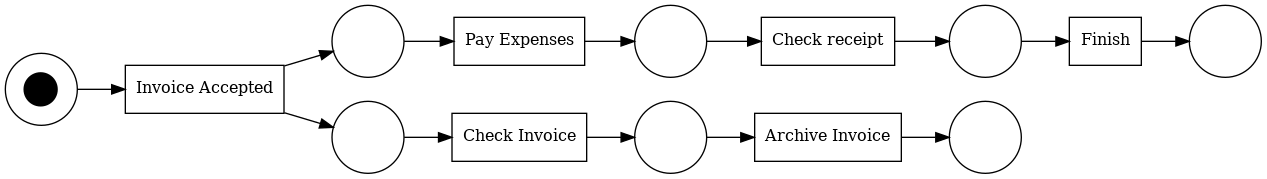

In [10]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking)
pn_visualizer.view(gviz)

In [11]:
parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, parameters=parameters)
pn_visualizer.save(gviz, "model_1.png")

In [12]:
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
pnml_exporter.apply(net, initial_marking, "experiment_1.pnml")

### Create Reachability Graph

In [13]:
from pm4py.objects.petri_net.utils import reachability_graph

reach = reachability_graph.construct_reachability_graph(net, initial_marking)

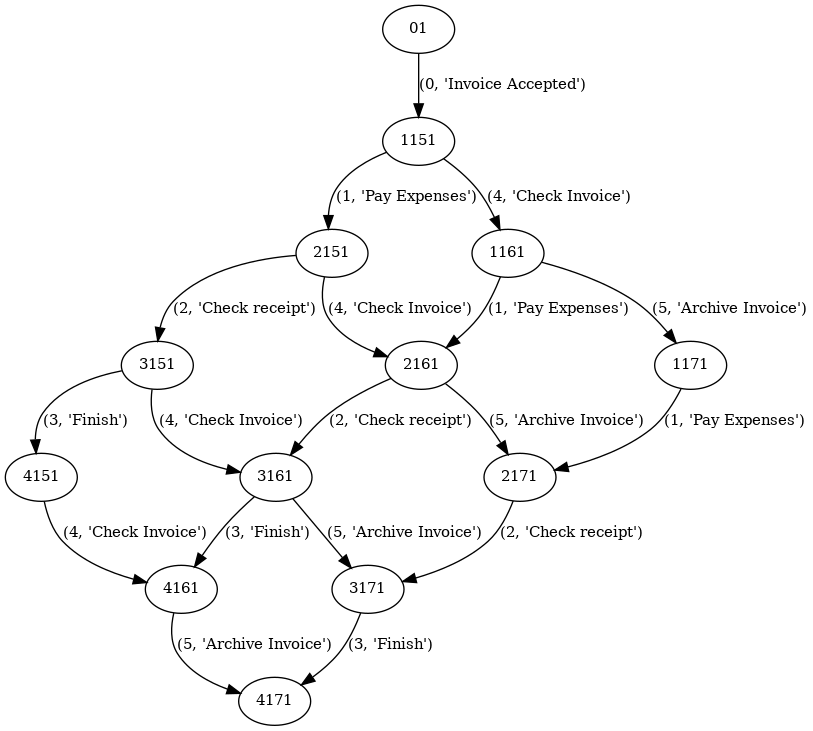

In [14]:
from pm4py.visualization.transition_system import visualizer as ts_visualizer

gviz = ts_visualizer.apply(reach)
ts_visualizer.view(gviz)

In [15]:
parameters = {ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT: "png"}
gviz = ts_visualizer.apply(reach, parameters=parameters)
pn_visualizer.save(gviz, "reach_graph_model_1.png")

### Simulate Event Logs

In [16]:
%%time

from pm4py.algo.simulation.playout.petri_net import algorithm as simulator

simulated_log = simulator.apply(net, initial_marking, variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 100000})

CPU times: user 19.7 s, sys: 223 ms, total: 20 s
Wall time: 20 s


In [17]:
%%time
from pm4py.objects.conversion.log import converter as log_converter
df = log_converter.apply(simulated_log, variant=log_converter.Variants.TO_DATA_FRAME)

CPU times: user 2.24 s, sys: 60.4 ms, total: 2.3 s
Wall time: 2.3 s


In [18]:
df

,concept:name,time:timestamp,case:concept:name
0,Invoice Accepted,1970-04-26 17:46:40,0
1,Check Invoice,1970-04-26 17:46:41,0
2,Archive Invoice,1970-04-26 17:46:42,0
3,Pay Expenses,1970-04-26 17:46:43,0
4,Check receipt,1970-04-26 17:46:44,0
...,...,...,...
599995,Pay Expenses,1970-05-03 16:26:35,99999
599996,Check receipt,1970-05-03 16:26:36,99999
599997,Check Invoice,1970-05-03 16:26:37,99999
599998,Finish,1970-05-03 16:26:38,99999


In [19]:
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

xes_exporter.apply(df, "experiment_1.xes")

exporting log, completed traces ::   0%|          | 0/100000 [00:00<?, ?it/s]

In [20]:
df.rename({'concept:name':'activity','case:concept:name':'trace_id','time:timestamp':'timestamp'},axis=1,inplace=True)

In [21]:
df.set_index('trace_id',inplace=True)

In [22]:
res=[]
for i,g in df.groupby(df.index):
    for a in g['activity']:
        res.append([i,a])
df=pd.DataFrame(res,columns=['trace_id','activity'])
df

,trace_id,activity
0,0,Invoice Accepted
1,0,Check Invoice
2,0,Archive Invoice
3,0,Pay Expenses
4,0,Check receipt
...,...,...
599995,99999,Pay Expenses
599996,99999,Check receipt
599997,99999,Check Invoice
599998,99999,Finish


In [23]:
df.set_index('trace_id',inplace=True)

In [24]:
df['event_id']=df.groupby(df.index).cumcount()

In [25]:
len(df.index.unique())

100000

0    24778
1    12611
2    12594
3    12552
4     6341
5     6330
6     6302
7     6224
8     6184
9     6084
Name: activity, dtype: int64

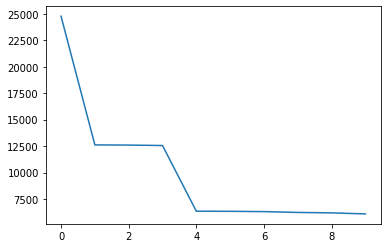

In [26]:
traces=df.groupby(df.index)['activity'].apply(lambda x:"->".join(list(x)))

traces = traces.value_counts()

traces.index = range(len(traces))

traces.plot()
traces

## Deep Learning

In [27]:
from mppn.imports import *
from mppn.preprocessing import *
from mppn.pipeline import *
from mppn.baselines import *

In [28]:
seed = 99
splits = split_traces(df,validation_seed=seed,test_seed=seed)

In [29]:
df

,activity,event_id
trace_id,,
0,Invoice Accepted,0
0,Check Invoice,1
0,Archive Invoice,2
0,Pay Expenses,3
0,Check receipt,4
...,...,...
99999,Pay Expenses,1
99999,Check receipt,2
99999,Check Invoice,3


In [30]:
o=PPObj(df,[Categorify()],cat_names=['activity'],y_names='activity',splits=splits)
o.show(max_n=2)
dls=o.get_dls(windows=partial(subsequences_fast,min_ws=0))
xcat,y=dls.one_batch()
xcat.shape,y.shape

#traces: 100000 #events: 600000


,activity
trace_id,
27288,5
27288,6


(torch.Size([64, 5]), torch.Size([64]))

In [31]:
class Camargo_specialized(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        emb_dim_act = int(sqrt(vocab_act))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)

        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)
    def forward(self, xcat):
        x_act = self.emb_act(xcat)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        return x_act

In [32]:
m=Camargo_specialized(o)

In [33]:
p=m(xcat)

In [34]:
F.cross_entropy(p,y)

tensor(1.9470, grad_fn=<NllLossBackward>)

In [35]:
accuracy(p,y)

TensorBase(0.0938)

In [36]:
def plot_confusion_matrix(m,color="light:b",pct=False):
    p=m(dls.valid_ds.inp[0].cuda())
    p=p.argmax(dim=1).cpu()

    y=dls.valid_ds.inp[1][0].cpu()

    def pct_cm(cm):
        m=np.zeros(cm.shape, dtype=float) 
        for i in range(len(cm[0])):
            summe=sum(cm[:,i])
            m[:,i]=(cm[:,i]/summe).round(2)
        return(m)



    pcm=confusion_matrix(y, p)
    if pct:
        pcm=pct_cm(pcm)
    
    vocab=o.categorify['activity'][y.unique().cpu().tolist()]

    cm_cols=o.categorify['activity'][np.unique(p.unique().cpu().tolist()+y.unique().cpu().tolist())]


   

    df_cm = pd.DataFrame(pcm, index = cm_cols, columns = cm_cols)
    plt.figure(figsize = (7, 7))
    sn.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap=sn.color_palette(color, as_cmap=True))
    plt.tight_layout()
    plt.savefig("conf_matrix_model_1_2.png")

In [37]:
import random
import networkx as nx
import re

class ModelBasedAssessment():
    def __init__(self, reach_graph):

        self.reachability_graph = reach_graph

        self.paths = None
        self.subpaths = None


    def get_start_state(self):
        """
        Get the first state, i.e. the starting state of the reachability graph.

        :return:
        """

        for s in self.reachability_graph.states:
            if s.incoming == set():
                return s

    def get_start_node(self):
        """
        Get the first node in the networkx graph

        :return:
        """
        start_state = self.get_start_state()
        return start_state.name

    def get_end_state(self):
        """
        Get the last state, i.e. the end state of the reachability graph.

        :return:
        """

        for s in self.reachability_graph.states:
            if s.outgoing == set():
                return s


    def indicator_function(self, y_hat, y):
        if y_hat in y:
            return 1
        else:
            return 0



    def compute_accuracy(self, prefixes, predictions):
        correct_pred = 0

        #Case where no path have been computed as reachability graph was to massive. Replay the prefix in the graph.
        if self.paths is None:
            start_state = self.get_start_state()

            for p_t, y_hat in zip(prefixes, predictions):
                gt = self.replay_prefix(p_t, start_state)
                #print(y_hat, gt)

                correct_pred += self.indicator_function(y_hat, gt)

        #If gt has been pre-computed.
        else:
            for p_t, y_hat in zip(prefixes, predictions):
                gt = self.ground_truth[tuple(p_t)]
                #print(y_hat, gt)
                correct_pred += self.indicator_function(y_hat, gt)

        accuracy = float(correct_pred/len(prefixes))

        return accuracy


    def replay_prefix(self, prefix, start_state):
        """
        Replay the prefix to collect the ground truth.
        Steps:
        - Walk the reachability graph with the activity names util reaching the final state(s).
        - All activates transitions from that state(s) form the ground truth which is returned.

        :param prefix:          The prefix, i.e., the unfinished case.
        :param start_state:     The state to start.

        :return:                A list of possible next steps to happen.
        """

        #print(f"\n\n---------------------------------\n{prefix}\n-----------------------------------\n\n")

        """Holds (current_state, reachable_state)"""
        states = [(start_state, start_state)]

        """Holds (state, enabled_transitions)"""
        enab_trans = self.get_enab_trans_from_state_set(states)

        if self.check_for_silent_trans(enab_trans):
            enab_trans, current_states = self.walk_silent_trans(enab_trans, states)

        for act_name in prefix:
            #print("\n")
            #print(f"Activity:                           {act_name}")
            #print(f"Current states:                     {states}")
            #print(f"Enabled transitions:                {enab_trans}")
            #print([t.name[5:len(t.name)-2] for (s, trans) in enab_trans for t in trans])

            #Check if trans is in the set of the directly reachable transitions
            if act_name in [t.name[5:len(t.name)-2] for (s, trans) in enab_trans for t in trans]:
                #Collect all next states, possible many as transition names can be ambignous in the petri nets
                states = []
                for (from_state, trans) in enab_trans:
                    for t in trans:
                        if t.name[5:len(t.name)-2] == act_name:
                            states.append((from_state, t.to_state))

                #Collect directly reachable transitions
                direct_trans = self.get_enab_trans_from_state_set(states)
                #print(direct_trans)

                if self.check_for_silent_trans(direct_trans):
                    enab_trans, states = self.walk_silent_trans(direct_trans, states)

                else:
                    enab_trans = direct_trans

            else:
                #raise ValueError(f"Cannot replay prefix {prefix}. {act_name} not in enabled transitions {enab_trans}")
                print(f"Cannot replay prefix {prefix}. {act_name} not in enabled transitions {enab_trans}")
                return []
        
        gt = [t.name[5:len(t.name)-2] for (s, tr) in enab_trans for t in tr]
        # print(p_t, y_hat)
        #print(gt)
        # print("\n")

        return gt



    def walk_silent_trans(self, direct_trans, states):
        """
        Collect all states and transitions that can be reached from the current state by walking silent transitions.

        :param direct_trans:        Directly enabled transitions (s, t) without silent transitions.
        :param next_states:         Reachable states (s, s) from that transitions.
        :return:
        """

        def add_missing_transitions(old_trans, new_trans):
            for (st, tr) in new_trans:
                if st not in [s for (s, t) in old_trans]:
                    trans.append((st, tr))
                elif tr not in [t for (s, t) in old_trans]:
                    trans.append((st, tr))


        trans = direct_trans

        while self.check_for_silent_trans(trans):
            silent_trans = [(s, t) for (s, tr) in trans for t in tr if "n" in t.name]

            """Holds (state, to_state)"""
            new_states_from_silent = []
            for (s, t) in silent_trans:
                new_states_from_silent.append((s, t.to_state))

            new_trans = False
            for (from_state, to_state) in new_states_from_silent:
                if from_state not in [f for (f, t) in states]:
                    states.append((from_state, to_state))
                    new_trans = True
                elif to_state not in [t for (f, t) in states]:
                    states.append((from_state, to_state))
                    new_trans = True


            direct_trans = self.get_enab_trans_from_state_set(states)

            #Break the loop if no new transitions have been found
            if not new_trans:
                #print("No new states found.")
                add_missing_transitions(trans, direct_trans)
                break

            #Otherwise add the new transitions to the reachable ones
            else:
                add_missing_transitions(trans, direct_trans)
                #print(f"New state(s) found. Adding {trans}")

        return trans, states


    def check_for_silent_trans(self, trans):
        """
        Checks whether a silent transition is in trans. A silent transition is one with the pattern [n][number] in pm4py.
        :param trans:
        :return:
        """
        for (s, t) in trans:
            for transition in t:
                if re.search("^[n]+[\d]", transition.name):
                    return True

        return False

    def get_enab_trans_from_state_set(self, states):
        """
        Collect all reachable states from states as tuple (state, to_state).

        :param states:
        :return:
        """
        enab_trans = [(to_state, to_state.outgoing) for (from_state, to_state) in states]
        return enab_trans


In [38]:
mba = ModelBasedAssessment(reach)

In [39]:
mba.compute_accuracy([["Invoice Accepted"]], ["Pay Expenses"])

1.0

In [40]:
mba.compute_accuracy([["Invoice Accepted"]], ["Invoice Accepted"])

0.0

In [41]:
mba.compute_accuracy([["Invoice Accepted"]], ["Check receipt"])

0.0

In [42]:
mba.compute_accuracy([["Invoice Accepted", "Pay Expenses"]], ["Check receipt"])

1.0

In [43]:
mba.compute_accuracy([["Invoice Accepted", "Pay Expenses"]], ["Finish"])

0.0

### Simple-LSTM

In [44]:
def training_loop(learn,epoch,print_output,lr):
    '''
    Basic training loop that uses learning rate finder and one cycle training.
    See fastai docs for more information
    '''
    learn.fit(epoch, lr)
    
    
def train_validate(dls,m,metrics=accuracy,loss=F.cross_entropy,epoch=20,print_output=True,model_dir=".",lr=5e-5,
                   output_index=1,patience=3,min_delta=0.005,show_plot=True,store_path='tmp',model_name='.model'):
    '''
    Trains a model on the training set with early stopping based on the validation loss.
    Afterwards, applies it to the test set.
    '''
    cbs = [CudaCallback,
      EarlyStoppingCallback(monitor='valid_loss',min_delta=min_delta, patience=patience),
      SaveModelCallback(fname=model_name)
      ]
    learn=Learner(dls, m, path=store_path, model_dir=model_dir, loss_func=loss ,metrics=metrics,cbs=cbs)

    if print_output:
        training_loop(learn,epoch,show_plot, lr=lr)
        return learn.validate(dl=dls[2])[output_index]
    else:
        with HideOutput(),learn.no_bar(),learn.no_logging():
            training_loop(learn,epoch,show_plot, lr=lr)
            return learn.validate(dl=dls[2])[output_index]

In [45]:
m1=Camargo_specialized(o)
train_validate(dls,m1,loss=F.cross_entropy,metrics=accuracy,epoch=20,lr=5e-5,print_output=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.663399,1.663301,0.524100,00:42
1,1.532417,1.523975,0.662450,00:41
2,1.497064,1.496212,0.662450,00:41
3,1.494236,1.492102,0.662450,00:42
4,1.483885,1.491071,0.662450,00:40
5,1.491468,1.490652,0.663150,00:42
6,1.493684,1.490451,0.663000,00:42
7,1.487260,1.490443,0.662450,00:42


Better model found at epoch 0 with valid_loss value: 1.6633012294769287.
Better model found at epoch 1 with valid_loss value: 1.5239746570587158.
Better model found at epoch 2 with valid_loss value: 1.4962120056152344.
Better model found at epoch 3 with valid_loss value: 1.4921022653579712.
Better model found at epoch 4 with valid_loss value: 1.4910706281661987.
Better model found at epoch 5 with valid_loss value: 1.4906522035598755.
Better model found at epoch 6 with valid_loss value: 1.4904507398605347.
No improvement since epoch 4: early stopping


Better model found at epoch 0 with valid_loss value: 0.6621500253677368.


0.6621500253677368

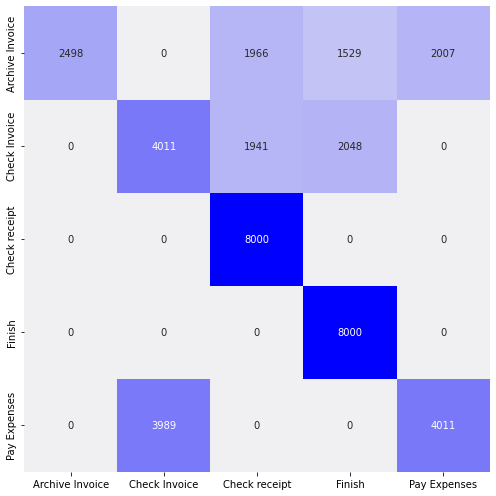

In [46]:
plot_confusion_matrix(m1)

In [47]:
p=m1(dls.valid_ds.inp[0].cuda())
p=p.argmax(dim=1).cpu()
y=dls.valid_ds.inp[1][0].cpu()
y = y.cpu().tolist()

In [48]:
v = o.categorify['activity']

In [49]:
y_enc = [v[a] for a in y]


In [50]:
x = dls.valid_ds.inp[0].cpu()

In [51]:
x_enc = []

for pref in x:
    pref_enc = []
    for a in pref:
        if a != 0 and a != 7:
            pref_enc.append(v[a])
    
    if pref_enc != []:
        x_enc.append(pref_enc)


In [52]:
x_enc[1]

['Invoice Accepted', 'Pay Expenses']

In [53]:
mba = ModelBasedAssessment(reach)

In [54]:
mba.compute_accuracy(x_enc, y_enc)

1.0